<a href="https://colab.research.google.com/github/jdcast/dl-final-project/blob/main/CPC_3D_encoder_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Embeddings CPC image sequences encoder for consecutive sequences of frames
- extract latent space representations of consecutive sequences of frames
- useful for trying to group/cluster the embeddings of images sequences are clustered closely -> meaning that they may likely represent consecutive sequences of sequences of images
- CPC images sequences model reference: https://colab.research.google.com/drive/1XeGnR55SgTahjv4aVRiIgKvlShN_uA99#scrollTo=F4-53HZ7mgOx&uniqifier=1

## Imports

In [34]:
import os
import pdb
import time
import random

%matplotlib inline
import torch as T
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import randrange
from random import choice
from random import uniform
from torchsummary import summary
from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as functional
import torchvision.transforms.functional as TF
from scipy.stats import entropy
from scipy.stats import iqr
from tqdm import tqdm
import copy

from skimage import io

import itertools
# For loading .mat file
import scipy.io

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()
print("GPU Available: {}".format(gpu_boole))

GPU Available: False


## Mount Google Drive

In [35]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Dataset

## Data Directory

In [36]:
# Image.open('/content/gdrive/My Drive/Colab Notebooks/CPC/lena.jpeg')

In [37]:
#address of data in google drive 
data_dir = '/content/gdrive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset'

## Display Sample of Data

(538, 701, 3)


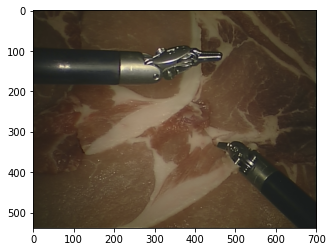

In [38]:
test_img_path = os.path.join(data_dir, "Video_01/images/000.png")
test_img = io.imread(test_img_path)
plt.imshow(test_img)
print(test_img.shape) #original img dimension

In [39]:
mat = scipy.io.loadmat(os.path.join(data_dir, 'Video_01/kinematic.mat'))
print(mat.keys())
mat

dict_keys(['__header__', '__version__', '__globals__', 'jaw_values1', 'jaw_values3', 'joint_values1', 'joint_values3', 'ecm_values'])


{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 29 11:59:49 2020',
 '__version__': '1.0',
 'ecm_values': array([[-0.08814785, -0.08814785, -0.08814785, ..., -0.08814785,
         -0.08814785, -0.08814785],
        [-0.46083237, -0.46083237, -0.46083237, ..., -0.46083237,
         -0.46083237, -0.46083237],
        [ 0.17415773,  0.17415773,  0.17415773, ...,  0.17415773,
          0.17415773,  0.17415773],
        [ 0.60085643,  0.60085643,  0.60085643, ...,  0.60085643,
          0.60085643,  0.60085643]]),
 'jaw_values1': array([[-0.16308299, -0.1631538 , -0.16308299, ...,  0.0143751 ,
          0.01472916,  0.01479998]]),
 'jaw_values3': array([[-0.16824439, -0.16824439, -0.17102124, ...,  0.06876785,
          0.07105467,  0.07350483]]),
 'joint_values1': array([[ 0.48887216,  0.4939151 ,  0.4958149 , ...,  0.65067114,
          0.65058619,  0.65053213],
        [-0.26129094, -0.25934482, -0.25895868, ..., -0.18256541,
         -0.18

## Dataloader Architecture
 - returns sequences of image sequences
 - return shape: (terms+predict_terms, c, frames, h, w)

### Video dataloader

In [40]:
class ImageDataset(Dataset):
    """
    Image Dataset
    """

    def __init__(self, data_dir, op, frame = 10, transform=False):
        """
        Args:
            input_dir: input data path to images and masks
        """
        assert frame > 1, 'number of frames should be an integer greater than 1'

        self.frame = frame
        self.op = op # specify train or test 
        self.data_dir = data_dir
        self.transform = transform
        self.mask_num = 2 # Only 2 output class labels.
        
        try:
          if self.op == 'train':
              self.len = 300 * 8 // frame # Videos 1-8 with 300 frames each.
          elif self.op == 'val':
              self.len = 300 * 2 // frame # Videos 9-10.
          elif self.op == 'test':
              self.len = 300 * 4 // frame # Videos 11-14.
        except ValueError:
          print ('op should be train or test.')
    
    
    def __len__(self):
        """
          for training: using videos from 01-14 each with 300 pics (14 * 300 img in total)
          for testing: using videos from 15-20 each with 300 pics (6 * 300 img in total)
        """
        return self.len

    def __getitem__(self, idx):
        """
          returning corresponding img and mask from dataset folder 
        """

        video_id = (idx * self.frame) // 300 + 1 #returning the number part of video's name str (i.e. "Video_01"'s '01')

        if self.op == 'train':
            video_name = str(video_id).zfill(2) 
        elif self.op == 'val':
            video_id = (idx * self.frame) // 300 + 9
            video_name = str(video_id).zfill(2)
        else:
            video_id = (idx * self.frame) // 300 + 11
            video_name = str(video_id).zfill(2)
        
        img_dir = os.path.join(self.data_dir, "Video_" + video_name, "images")
        mask_dir = os.path.join(self.data_dir,"Video_" + video_name, "ground_truth")

        frames = [(idx * self.frame + i) % 300 for i in range(self.frame)]
        # start = np.random.randint(100)
        # interval = np.random.randint(5, 10)
        # print (start, interval)
        # frames = [start for _ in range(self.frame)]

        img_name = os.path.join(img_dir, str(frames[0]).zfill(3) + ".png")
        mask_name = os.path.join(mask_dir, str(frames[0]).zfill(3) + ".png")
        
        img = Image.open(img_name)
        mask = Image.open(mask_name)

        img = TF.resize(img, (256, 320), interpolation=TF.InterpolationMode.NEAREST)
        mask = TF.resize(mask, (256, 320), interpolation=TF.InterpolationMode.NEAREST)

        # Apply data augmentations, if any.
        if self.transform:
            img, mask = self.augment(img, mask)
        
        mask = np.array(mask)

        h, w, c  = mask.shape
        mask_value = {0:0, 1:255}
        
        # Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            new_mask[:, :, idx] = mask[:, :, 0] == mask_value[idx]

        # Transform to tensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(new_mask)

        img = torch.unsqueeze(img, 1)
        mask = torch.unsqueeze(mask, 1)
        
        # Concatenate images to videos
        for i in range(1, self.frame):

            img_name = os.path.join(img_dir, str(frames[i]).zfill(3) + ".png")
            mask_name = os.path.join(mask_dir, str(frames[i]).zfill(3) + ".png")
            
            img_next = Image.open(img_name)
            mask_next = Image.open(mask_name)

            img_next = TF.resize(img_next, (256, 320), interpolation=TF.InterpolationMode.NEAREST)
            mask_next = TF.resize(mask_next, (256, 320), interpolation=TF.InterpolationMode.NEAREST)
            
            # Apply data augmentations, if any.
            if self.transform:
                img_next, mask_next = self.augment(img_next, mask_next)
            
            mask_next = np.array(mask_next)
            
            # Convert grey-scale label to one-hot encoding
            new_mask = np.zeros((h, w, self.mask_num))
            for idx in range(self.mask_num):
                new_mask[:, :, idx] = mask_next[:, :, 0] == mask_value[idx]

            # Transform to tensor
            img_next = TF.to_tensor(img_next)
            mask_next = TF.to_tensor(new_mask)
            
            img_next = torch.unsqueeze(img_next, 1)
            mask_next = torch.unsqueeze(mask_next, 1)
            
            img = torch.cat((img,img_next),dim=1)
            mask = torch.cat((mask,mask_next),dim=1)

        # Load kinematic info
        kin_dir = os.path.join(self.data_dir, "Video_" + video_name)
        kin_name = kin_dir + "/kinematic.mat"
        kin_mat = scipy.io.loadmat(kin_name)
        ecm_values = torch.Tensor(kin_mat['ecm_values'])
        joint_values1 = torch.Tensor(kin_mat['joint_values1'])
        jaw_values1 = torch.Tensor(kin_mat['jaw_values1'])
        joint_values3 = torch.Tensor(kin_mat['joint_values3'])
        jaw_values3 = torch.Tensor(kin_mat['jaw_values1'])

        kin_all = torch.cat((ecm_values, joint_values1, jaw_values1, joint_values3, jaw_values3), 0)
        # It has 1500 time frames of kinematic for each video, but for the comparison with the original paper,
        # which says "collect every 150 ms to avoid redundance", i.e. reduce to the same frames/sec as the image data,
        # we also reduce the amount of kinematic data by slicing it at the step = 5
        kin_sampled = kin_all[:, 1:1500:5]
        kin_framed = kin_sampled[:, frames]
        kin = kin_framed

        return img, mask, kin



        # # Break sequence into multiple sequences
        # kin_framed = T.split(kin_framed, split_size_or_sections=self.frames_per_term, dim=1)
        # kin_frames = T.split(T.tensor(frames), split_size_or_sections=self.frames_per_term, dim=0)

        # # combined return lists into concatenated tensors so that they can be used during training
        # kin_framed_t = T.unsqueeze(kin_framed[0], 0)
        # frames_t = T.unsqueeze(kin_frames[0], 0)
        # for i in range(len(kin_framed)):
        #   if i > 0:
        #     kin_seq = T.unsqueeze(kin_framed[i], 0)
        #     kin_t = T.cat((kin_t, kin_seq), dim=0)

        #     frames_seq = T.unsqueeze(kin_frames[i], 0)
        #     frames_t = T.cat((frames_t, frames_seq), dim=0)


        # return kin

        

    def augment(self, img, mask):

        
        if np.random.random() > 0.5:

            # # Random horizontal flipping
            # if np.random.random() > 0.5:
            #     img = TF.hflip(img)
            #     mask = TF.hflip(mask)

            # # Random vertical flipping
            # if np.random.random() > 0.5:
            #     img = TF.vflip(img)
            #     mask = TF.vflip(mask)

            # Random brightness change
            if np.random.random() > 0.5:
                img = TF.adjust_brightness(img, np.random.uniform(0.5, 2))

            # Random contrast change
            if np.random.random() > 0.75:
                img = TF.adjust_contrast(img, np.random.uniform(0.5, 2))
            
            # Random hue change
            if np.random.random() > 0.8:
                img = TF.adjust_hue(img, np.random.uniform(-0.3, 0.3))

            # # Random equalize
            # if np.random.random() > 0.9:
            #     img = TF.equalize(img)

            # Random gaussian blur
            if np.random.random() > 0.9:
                img = TF.gaussian_blur(img, [3, 3])
        
        return img, mask

### Kinematic dataloader
Based on adopted video dataloader: https://drive.google.com/file/d/1RbeqAOOB0seUhvRHV7LlHqXcY3ugHLGq/view?usp=sharing

## Test Dataloaders

### Video dataloader test

In [24]:
batch_size = 5

train_dataset = ImageDataset(data_dir, op='train', transform=True)
val_dataset = ImageDataset(data_dir, op='val', transform=False)
test_dataset = ImageDataset(data_dir, op='test', transform=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

img, mask, kin = next(iter(train_dataloader))
print (img.shape, mask.shape, kin.shape)
fig = plt.figure(figsize=(20, 4))
columns = 10
rows = 2

for i in range(rows):
  for j in range(columns):
    if i == 0:
      image = torch.permute(img[0, :, j, :, :], (1, 2, 0)).cpu().numpy()
      fig.add_subplot(rows, columns, i * columns + j + 1)
      plt.imshow(image)
    else:
      image = torch.argmax(mask[0], dim=0)[j].cpu().numpy()
      fig.add_subplot(rows, columns, i * columns + j + 1)
      plt.imshow(image)

plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

# Encoder for CPC Image Sequences

### Define Architecture
- use encoder from 3D Vanilla UNet: https://colab.research.google.com/drive/1FtT3_qF5jcqHDazesrxkdaOtd2mvimdl#scrollTo=_kN-xXH00mey

In [41]:
# Encoder

## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding='same',
                   bias=True,
                   useBN=True):
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

def last_layer(dim_in,
               dim_out,
               kernel_size=3,
               stride=1,
               padding='same',
               bias=True,
               useBN=True):
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        )

class cpc_images_encoder(nn.Module):
  def __init__(self, useBN=True):
    super(cpc_images_encoder, self).__init__()

    # Downgrade stages
    if useBN:
      self.conv1 = nn.Sequential(
        nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
        nn.BatchNorm3d(32),
        nn.LeakyReLU(0.1))
    else:
      self.conv1 = nn.Sequential(
        nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
        nn.LeakyReLU(0.1))
    
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    self.last_layer = last_layer(256, 512, useBN=useBN)
    
    # Maxpool
    self.max_pool122 = nn.MaxPool3d(2, stride=(1, 2, 2))
    self.max_pool2 = nn.MaxPool3d(2)

    # weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()
        torch.nn.init.kaiming_uniform_(m.weight.data)
        
  def forward(self, inputs):
    """
    Forward pass
    """
    conv1_out = self.conv1(inputs)
    conv2_out = self.conv2(self.max_pool2(conv1_out))
    conv3_out = self.conv3(self.max_pool122(conv2_out))
    conv4_out = self.conv4(self.max_pool2(conv3_out))
    out = self.last_layer(self.max_pool2(conv4_out))

    return out

### Load Pretrained Model

In [42]:
cpc_images_encoder_path = "/content/gdrive/MyDrive/JHU/Courses/Deep Learning/DL_Project/runs/cpc_3d_encoder/1651693328_1302767/cpc_images_encoder.pth"
cpc_images_encoder_model = cpc_images_encoder()
checkpoint = T.load(cpc_images_encoder_path)
cpc_images_encoder_model.load_state_dict(checkpoint['model_state_dict'])

if gpu_boole:
  cpc_images_encoder_model = cpc_images_encoder_model.cuda()

cpc_images_encoder_model.eval()

cpc_images_encoder(
  (conv1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), pa

### Freeze Model

In [43]:
for child in cpc_images_encoder_model.children():
  for param in child.parameters():
    param.requires_grad = False

### Print Architecture

In [44]:
# image_shape = (512, 672)
image_shape = (256, 320)
frames_per_term = 10

summary(cpc_images_encoder_model, (3, frames_per_term, image_shape[0], image_shape[1])) # dataloader provides batches of shape: (batch_size, c, frames, h, w)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 10, 128, 160]           2,624
       BatchNorm3d-2     [-1, 32, 10, 128, 160]              64
         LeakyReLU-3     [-1, 32, 10, 128, 160]               0
         MaxPool3d-4        [-1, 32, 5, 64, 80]               0
            Conv3d-5        [-1, 64, 5, 64, 80]          55,360
       BatchNorm3d-6        [-1, 64, 5, 64, 80]             128
         LeakyReLU-7        [-1, 64, 5, 64, 80]               0
            Conv3d-8        [-1, 64, 5, 64, 80]         110,656
       BatchNorm3d-9        [-1, 64, 5, 64, 80]             128
        LeakyReLU-10        [-1, 64, 5, 64, 80]               0
        MaxPool3d-11        [-1, 64, 4, 32, 40]               0
           Conv3d-12       [-1, 128, 4, 32, 40]         221,312
      BatchNorm3d-13       [-1, 128, 4, 32, 40]             256
        LeakyReLU-14       [-1, 128, 4,

# Gather Embeddings For Sequences of 10 Consecutive Frames Across entire Dataset 

It's very weird that it only works for "for i, data in enumerate(dataloader)" 

In [45]:
batch_size = 5
output_dir = "/content/gdrive/MyDrive/JHU/Courses/Deep Learning/DL_Project/CPC_3D_encoder_embeddings/10_frames/1651693328_1302767"

train_dataset = ImageDataset(data_dir, op='train', transform=False)
val_dataset = ImageDataset(data_dir, op='val', transform=False)
test_dataset = ImageDataset(data_dir, op='test', transform=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

cpc_images_encoder_model.eval()

# train embeddings
train_embeddings = np.array([])
for idx, (img, mask, kin) in enumerate(tqdm(train_dataloader)):
    if gpu_boole:
      img = img.cuda()
    out = cpc_images_encoder_model.forward(img)
    if idx == 0:
      train_embeddings = out.cpu().detach().numpy()
    else:
      np.append(train_embeddings, out, axis=0)

np.save(os.path.join(output_dir, 'train_embeddings.npy'), train_embeddings) 

# validation embeddings
val_embeddings = np.array([])
for idx, (img, mask, kin) in enumerate(tqdm(val_dataloader)):
    if gpu_boole:
      img = img.cuda()
    out = cpc_images_encoder_model.forward(img)
    if idx == 0:
      val_embeddings = out.cpu().detach().numpy()
    else:
      np.append(val_embeddings, out, axis=0)

np.save(os.path.join(output_dir, 'val_embeddings.npy'), val_embeddings) 

# test embeddings
test_embeddings = np.array([])
for idx, (img, mask, kin) in enumerate(tqdm(test_dataloader)):
    if gpu_boole:
      img = img.cuda()
    out = cpc_images_encoder_model.forward(img)
    if idx == 0:
      test_embeddings = out.cpu().detach().numpy()
    else:
      np.append(test_embeddings, out, axis=0)

np.save(os.path.join(output_dir, 'test_embeddings.npy'), test_embeddings) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 24/24 [01:08<00:00,  2.86s/it]
